In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.remote import Remote
import pymoo.gradient.toolbox as anp
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
import scienceplots
import numpy as np

# mw3

In [3]:
class MW(Problem):
    def __init__(self, n_var, n_obj, n_ieq_constr, **kwargs):
        if 'xl' not in kwargs:
            kwargs['xl'] = 0
        if 'xu' not in kwargs:
            kwargs['xu'] = 1
        super().__init__(n_var=n_var,
                         n_obj=n_obj,
                         n_ieq_constr=n_ieq_constr,
                         vtype=float, **kwargs)

    @staticmethod
    def LA1(A, B, C, D, theta):
        return A * np.power(np.sin(B * np.pi * np.power(theta, C)), D)

    @staticmethod
    def LA2(A, B, C, D, theta):
        return A * np.power(np.sin(B * np.power(theta, C)), D)

    @staticmethod
    def LA3(A, B, C, D, theta):
        return A * np.power(np.cos(B * np.power(theta, C)), D)

    def g1(self, X):
        d = self.n_var
        n = d - self.n_obj

        z = np.power(X[:, self.n_obj - 1:], n)
        i = np.arange(self.n_obj - 1, d)

        exp = 1 - np.exp(-10.0 * (z - 0.5 - i / (2 * d)) * (z - 0.5 - i / (2 * d)))
        distance = 1 + exp.sum(axis=1)
        return distance

    def g2(self, X):
        d = self.n_var
        n = d

        i = np.arange(self.n_obj - 1, d)
        z = 1 - np.exp(-10.0 * (X[:, self.n_obj - 1:] - i / n) * (X[:, self.n_obj - 1:] - i / n))
        contrib = (0.1 / (n)) * z * z + 1.5 - 1.5 * np.cos(2 * np.pi * z)
        distance = 1 + contrib.sum(axis=1)
        return distance

    def g3(self, X):
        contrib = 2.0 * np.power(
            X[:, self.n_obj - 1:] + (X[:, self.n_obj - 2:-1] - 0.5) * (X[:, self.n_obj - 2:-1] - 0.5) - 1.0, 2.0)
        distance = 1 + contrib.sum(axis=1)
        return distance

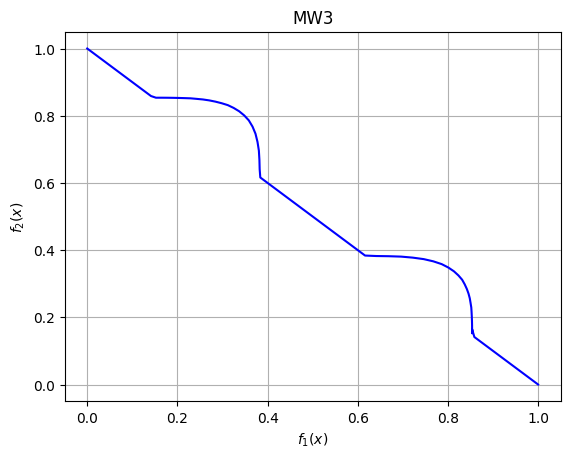

In [4]:
# 凸なパレートフロントを持つ問題
problem = get_problem("mw3")

# 問題の可視化
def plot(problem, solv=None, save_name=None):
    if solv is not None:
        plt.scatter(solv[:, 0], solv[:, 1], color='red')
    ans = problem.pareto_front()
    plt.plot(ans[:, 0], ans[:, 1], color='blue')
    plt.title(problem.name())
    plt.xlabel("$f_1(x)$")
    plt.ylabel("$f_2(x)$")
    plt.grid(True)
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()



plot(problem, save_name="mw3_pareto_front.png")

## 重み付き線形和

In [8]:
# linear weight sum method
#各重みについてF(x)=w1*f1(x)+w2*f2(x)を最小化
#最適化アルゴリズムにはGAを使用
class mw3_single_linear(MW):
    def __init__(self, weights, n_var=15, **kwargs):
        super().__init__(n_var, 2, 2)
        self.weights = weights

    def _evaluate(self, X, out, *args, **kwargs):
        g = self.g3(X)
        f0 = X[:, 0]
        f1 = g * (1 - f0 / g)

        f = self.weights[0] * f0 + self.weights[1] * f1

        g0 = f0 + f1 - 1.05 - self.LA1(0.45, 0.75, 1.0, 6.0, np.sqrt(2.0) * f1 - np.sqrt(2.0) * f0)
        g1 = 0.85 - f0 - f1 + self.LA1(0.3, 0.75, 1.0, 2.0, np.sqrt(2.0) * f1 - np.sqrt(2.0) * f0)
        out["F"] = np.column_stack([f, f])
        out["G"] = np.column_stack([g0, g1])

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            F = np.zeros((100, 2))
            F[:, 0] = np.linspace(0, 1, 100)
        else:
            F = ref_dirs
        F[:, 1] = 1 - F[:, 0]
        invalid = (0.85 - F[:, 0] - F[:, 1] + 0.3 * np.sin(0.75 * np.pi * np.sqrt(2) * (F[:, 1] - F[:, 0])) ** 2) > 0
        while invalid.any():
            F[invalid, :] *= 1.001
            invalid = (0.85 - F[:, 0] - F[:, 1] + 0.3 * np.sin(
                0.75 * np.pi * np.sqrt(2) * (F[:, 1] - F[:, 0])) ** 2) > 0
        return F

def linear_weight_sum_method(problem, weights):
    F = []
    points = []
    for w in weights:
        problem_single = mw3_single_linear(w, n_var=30)
        res = minimize(problem_single, GA(), termination=('n_gen', 100))
        F.append(res.F)
        points.append(res.X)

    F = np.row_stack(F)
    points = np.row_stack(points)

    return (F, points)


weights1 = np.linspace(0, 1, 100)
weights = np.column_stack([weights1, 1 - weights1])
F, points = linear_weight_sum_method(problem, weights)

AssertionError: FitnessSurvival can only used for single objective single!

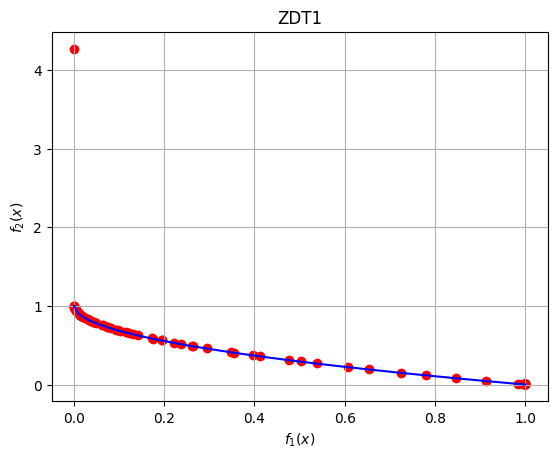

In [22]:
solv = problem.evaluate(points)
plot(problem, solv, save_name="zdt1_linear_weight_sum_method.png")


## チャビシェフスカラー化

In [25]:
# チャビシェフスカラー化
#最適化アルゴリズムにはGAを使用
class ZDT1_single_cheb(ZDT):
    def __init__(self, weights, n_var=30, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        f = np.maximum(self.weights[0] * f1, self.weights[1] * f2)
        out["F"] = anp.column_stack([f])

def chebyshev_scalarization(problem, weights):
    F = []
    points = []
    for w in weights:
        problem_single = ZDT1_single_cheb(w, n_var=30)
        res = minimize(problem_single, GA(), termination=('n_gen', 100))
        F.append(res.F)
        points.append(res.X)

    F = np.row_stack(F)
    points = np.row_stack(points)

    return (F, points)


weights1 = np.linspace(0, 1, 100)
weights = np.column_stack([weights1, 1 - weights1])
F, points = chebyshev_scalarization(problem, weights)

C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\405750784.py:29: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  F = np.row_stack(F)
C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\405750784.py:30: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  points = np.row_stack(points)


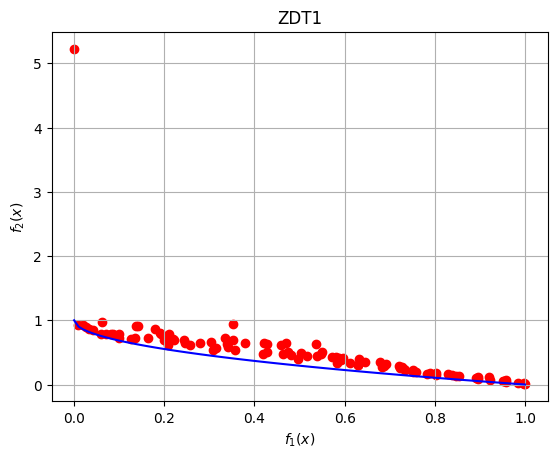

In [26]:
solv = problem.evaluate(points)
plot(problem, solv, save_name="zdt1_chebyshev_scalarization.png")

## 拡大チャビシェフスカラー化

In [27]:
# チャビシェフスカラー化
#最適化アルゴリズムにはGAを使用
class ZDT1_single_augcheb(ZDT):
    def __init__(self, weights, n_var=30, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        f = 0.001 * (self.weights[0] * f1 + self.weights[1] * f2)
        f += np.maximum(self.weights[0] * f1, self.weights[1] * f2)
        out["F"] = anp.column_stack([f])

def augmented_chebyshev_scalarization(problem, weights):
    F = []
    points = []
    for w in weights:
        problem_single = ZDT1_single_augcheb(w, n_var=30)
        res = minimize(problem_single, GA(), termination=('n_gen', 100))
        F.append(res.F)
        points.append(res.X)

    F = np.row_stack(F)
    points = np.row_stack(points)

    return (F, points)


weights1 = np.linspace(0, 1, 100)
weights = np.column_stack([weights1, 1 - weights1])
F, points = augmented_chebyshev_scalarization(problem, weights)

C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\288766084.py:30: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  F = np.row_stack(F)
C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\288766084.py:31: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  points = np.row_stack(points)


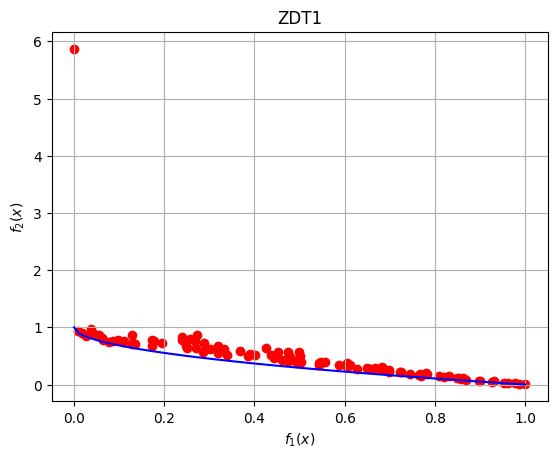

In [28]:
solv = problem.evaluate(points)
plot(problem, solv, save_name="zdt1_augmented_chebyshev_scalarization.png")

# CTP6